In [1]:
import os
import pandas as pd
import numpy as np
import random
from deap import base, creator, tools, algorithms

np.random.seed(42)  # for reproducibility
# Get the current working directory
current_directory = os.getcwd()

# Construct the relative path to prediction RUL file
rul_filename = "RUL_consultancy_predictions_A3-2.csv"
rul_path = os.path.join(current_directory, rul_filename)

# Read the CSV file
rul_df = pd.read_csv(rul_path, delimiter=';')
print(rul_df)


    RUL   id
0   135    1
1   125    2
2    63    3
3   100    4
4   103    5
..  ...  ...
95  140   96
96  109   97
97   87   98
98  127   99
99   24  100

[100 rows x 2 columns]


In [2]:
# Define constants
M = len(rul_df) # number of engines
G = 4 # Total number of teams (2 type A, 2 type B)
T = 30 # Planning horizon in days
MAX_DAILY_COST = 250

In [3]:
# Define maintenance times for teams A and B
maintenance_duration_a = [4 if i < 20 else 3 if 20 <= i < 55 else 2 if 55 <= i < 80 else 8 for i in range(1, M + 1)]
maintenance_duration_b = [time_a + 1 if i < 25 else time_a + 2 if 25 <= i < 70 else time_a + 1 for i, time_a in enumerate(maintenance_duration_a, start=1)]


# Define engine costs
engine_costs = [4 if i < 21 else 3 if 21 <= i < 31 else 2 if 31 <= i < 46 else 5 if 46 <= i < 81 else 6 for i in range(1, M + 1)]



In [4]:
def generate_random_schedule(T):
    individual = []
    # Track the availability of each team (A and B) on each day
    team_availability = {day: {'A': 0, 'B': 0} for day in range(1, T + 1)}

    # Apply filter to  allocate teams to engines that have a predicted safety due date of less than T = 30.

    filtered_df = rul_df[rul_df['RUL'] <= T].copy()
    engine_ids = list(filtered_df['id'])
    random.shuffle(engine_ids)

    # print("Engine IDs:", engine_ids)

    # Randomly assign teams to engines within the planning horizon
    for engine_id in engine_ids:
        engine_index = engine_id - 1
        team_type = np.random.choice(['A', 'B'])  # Assume team type is A for this example

        # Determine maintenance duration based on team type
        maintenance_days = maintenance_duration_a[engine_index] if team_type == 'A' else maintenance_duration_b[engine_index]
        valid_start_dates = []

        # Search for valid start dates with continuous available days for maintenance duration
        for start_day in range(1, T - maintenance_days + 2):
            is_valid = True
            for day in range(start_day, start_day + maintenance_days):
                if team_availability[day][team_type] >= 2:  # Check if max team limit is exceeded on any day
                    is_valid = False
                    break
            if is_valid:
                valid_start_dates.append(start_day)

        if not valid_start_dates:
            continue

        start_day = np.random.choice(valid_start_dates)
        end_day = start_day + maintenance_days - 1

        # Update team availability for the selected team and days
        for day in range(start_day, end_day + 1):
            team_availability[day][team_type] += 1

        # Append to individual list
        individual.append((engine_index, team_type, start_day))

    return individual

# Define the problem as a minimization problem
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
# Initialization functions for individual and population.
def init_individual(T):
    return creator.Individual(generate_random_schedule(T))

def init_population(size, T):
    return [init_individual(T) for _ in range(size)]

In [5]:

# Calculates penalty cost per engine
def calculate_penalty(engine_index, team_type, start_day,):
    RUL = rul_df.loc[engine_index, 'RUL']
    safety_due_date = RUL
    maintenance_days = maintenance_duration_a[engine_index] if team_type == 'A' else maintenance_duration_b[engine_index]
    end_day = start_day + maintenance_days - 1
    penalty = 0

    if end_day > safety_due_date:
        overdue_days = end_day - safety_due_date
        penalty = min(MAX_DAILY_COST, engine_costs[engine_index] * overdue_days ** 2)

    return penalty

# Define the fitness function.
def evaluate(individual):
    """Fitness function for the individual. Returns total penalty cost for the individual"""
    total_penalty = 0
    for engine_index, team_type, start_day in individual:
        penalty = calculate_penalty(engine_index, team_type, start_day)
        total_penalty += penalty

    return (total_penalty,)

# Check invalid individuals
def feasible(individual):
    """Feasibility function for the individual. Returns True if feasible False
    otherwise."""
    team_availability = {day: {'A': 0, 'B': 0} for day in range(1, T + 1)}
    unique_engines = set()
    # Constraints:
    for engine_index, team_type, start_day in individual:
        # An engine can be maintained at most once.
        if engine_index in unique_engines:
            return False

        maintenance_days = maintenance_duration_a[engine_index] if team_type == 'A' else maintenance_duration_b[engine_index]
        end_day = start_day + maintenance_days - 1
        
        # Incomplete schedules are not allowed. 
        if end_day > T:
            return False
        
        # A team can maintain one engine at a time
        for day in range(start_day, end_day + 1):
            if team_availability[day][team_type] >= 2:
                return False
            team_availability[day][team_type] += 1

        unique_engines.add(engine_index)

    return True


In [6]:
# Register genetic algorithm operators
toolbox = base.Toolbox()
toolbox.register("individual", init_individual)
toolbox.register("population", init_population)
toolbox.register("evaluate", evaluate)
toolbox.decorate("evaluate", tools.DeltaPenalty(feasible, 10000))
toolbox.register("mate", tools.cxTwoPoint)
# toolbox.register("mutate", tools.mutShuffleIndexes(individual, indpb=0.01))
toolbox.register("select", tools.selTournament, tournsize=3)

# Evolution parameters
ngen = 50  # Generations

# Create the population
pop = toolbox.population(size=1000, T=T)
# Hall of Fame and Statistics
hof = tools.ParetoFront()
stats = tools.Statistics(lambda ind: ind.fitness.values)

# Register statistics
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

In [7]:
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.0,
                                   ngen=ngen, stats=stats, halloffame=hof)

gen	nevals	avg       	std           	min   	max    
0  	1000  	[1472.206]	[331.82226201]	[494.]	[2492.]
1  	642   	[6791.999]	[4233.6053034]	[559.]	[10000.]
2  	682   	[7882.71] 	[3780.04631822]	[559.]	[10000.]
3  	708   	[8472.69] 	[3352.53079358]	[559.]	[10000.]
4  	716   	[8999.697]	[2817.78732398]	[559.]	[10000.]
5  	728   	[9242.937]	[2500.99032246]	[559.]	[10000.]
6  	696   	[9329.89] 	[2371.31753755]	[559.]	[10000.]
7  	710   	[9481.907]	[2108.32654453]	[559.]	[10000.]
8  	710   	[9489.3]  	[2097.7615365] 	[559.]	[10000.]
9  	696   	[9534.483]	[2008.96141369]	[559.]	[10000.]
10 	698   	[9523.372]	[2036.00923417]	[559.]	[10000.]
11 	664   	[9476.32] 	[2131.0339574] 	[559.]	[10000.]
12 	696   	[9575.739]	[1932.80254886]	[559.]	[10000.]
13 	666   	[9549.593]	[1985.00303611]	[559.]	[10000.]
14 	676   	[9493.066]	[2102.06318878]	[559.]	[10000.]
15 	752   	[9568.25] 	[1944.99307287]	[559.]	[10000.]
16 	704   	[9493.458]	[2100.50590055]	[559.]	[10000.]
17 	686   	[9584.986]	[1912.78687

In [8]:
# Best Solution
best_individual = tools.selBest(pop, 1)[0]

def convert_best_individual_to_schedule(individual):
    schedule = []
    
    for engine_index, team_type, start_day in individual:
        engine_id = engine_index + 1
        maintenance_days = maintenance_duration_a[engine_index] if team_type == 'A' else maintenance_duration_b[engine_index]
        end_day = start_day + maintenance_days - 1
        RUL = rul_df.loc[engine_index, 'RUL']
        penalty_cost = calculate_penalty(engine_index, team_type, start_day)
        total_penalty_cost = evaluate(individual)[0]
        schedule.append({
            'Predicted_RUL': RUL,
            'Engine_id': engine_id,
            'Team': team_type, 
            'Start_date': start_day,
            'End_date': end_day,
            'Penalty_cost': penalty_cost,
            'Total_penalty_cost': total_penalty_cost
        })
    
    
    return pd.DataFrame(schedule)
    


schedule_df = convert_best_individual_to_schedule(best_individual)
schedule_df.to_csv('best_individual.csv', index=False)

print(schedule_df)


    Predicted_RUL  Engine_id Team  Start_date  End_date  Penalty_cost  \
0              26         24    B           5         8             0   
1              24         36    B          26        30            72   
2              21         37    B          13        17             0   
3               8         35    A          10        12            32   
4              27         77    B          26        28             5   
5              24         64    B          12        15             0   
6               3         76    B           1         3             0   
7              29         40    A          21        23             0   
8              24        100    B           4        12             0   
9              29         91    B          16        24             0   
10             18         66    A           8         9             0   
11             23         41    A          13        15             0   
12             23         61    B          20      

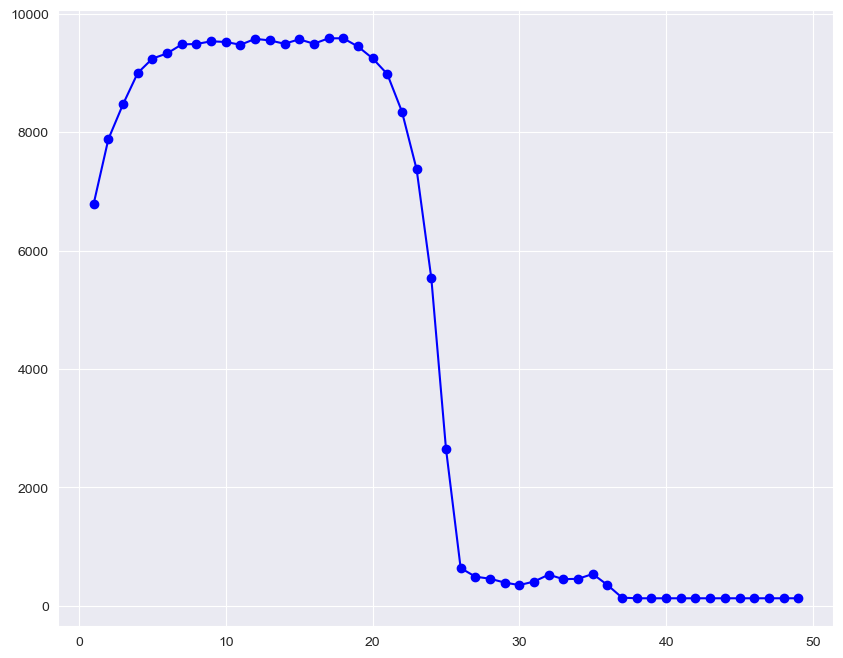

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# History AVG
plt.figure(figsize=(10,8))
front = np.array([(c['gen'], c['avg'][0]) for c in logbook])
plt.plot(front[:,0][1:-1], front[:,1][1:-1], "-bo")
plt.axis("tight")
plt.show()

In [10]:
import pandas as pd

def count_teams_starting_each_day(schedule_df):
    # Initialize a dictionary to hold the count of teams starting work each day
    days_count = {day: 0 for day in range(1, T + 1)}

    # Iterate through each row in the DataFrame
    for index, row in schedule_df.iterrows():
        start_day = row['Start_date']
        if start_day in days_count:
            days_count[start_day] += 1

    # Convert the dictionary to a pandas DataFrame for better readability
    days_count_df = pd.DataFrame(list(days_count.items()), columns=['Day', 'Teams_Starting'])
    
    return days_count_df

# Example usage
# Assume schedule_df is the DataFrame containing the maintenance schedule
days_count_df = count_teams_starting_each_day(schedule_df)

print(days_count_df)


    Day  Teams_Starting
0     1               2
1     2               2
2     3               0
3     4               2
4     5               1
5     6               0
6     7               0
7     8               1
8     9               1
9    10               1
10   11               0
11   12               1
12   13               2
13   14               0
14   15               0
15   16               1
16   17               0
17   18               0
18   19               0
19   20               1
20   21               2
21   22               0
22   23               0
23   24               0
24   25               0
25   26               2
26   27               0
27   28               0
28   29               0
29   30               0
